# Лабораторная работа 4.1 Построение и оценка модели для прогнозирования оттока клиентов

**Тема.** Интерпретация результатов модели для принятия бизнес-решений

**Курс.** Python для анализа данных

**Специальность.** Бизнес-информатика

### Цель работы:
Научиться применять модели машинного обучения (регрессию и классификацию) для решения реальных бизнес-задач, а также интерпретировать полученные результаты для формирования практических рекомендаций и принятия управленческих решений.

---

## Машинное обучение как инструмент бизнес-аналитика

В современном бизнесе данные — это стратегический актив. Способность предсказывать будущее поведение клиентов, оценивать риски и оптимизировать процессы напрямую влияет на прибыльность компании. Машинное обучение (ML) предоставляет для этого мощный инструментарий.

**Сквозной бизнес-кейс.** На протяжении всей этой работы мы будем решать одну из самых классических и важных задач — **прогнозирование оттока клиентов (Customer Churn)** на примере телеком-оператора.

**Почему это важно для бизнеса?**
- **Прямые финансовые потери.** Потерянный клиент — это потерянный доход.
- **Высокая стоимость привлечения.** Привлечь нового клиента в 5-7 раз дороже, чем удержать существующего.

Наша цель — не просто построить модель, которая предсказывает отток, а понять, **как использовать её результаты для реальных действий**: кому из клиентов предложить скидку, на какие факторы обратить внимание, чтобы снизить отток в будущем.

## Часть 1. Подготовка к анализу

Импортируем необходимые библиотеки и загрузим наш датасет.

In [1]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn scikit-learn -q

# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт инструментов для предобработки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Импорт метрик для оценки
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

**Задание 1: Загрузка и первичный осмотр данных**

Загрузите датасет по оттоку клиентов телеком-оператора по предоставленной ссылке. Выведите первые 5 строк (`.head()`) и общую информацию о данных (`.info()`).

In [2]:
# URL датасета
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# 1. Загрузите данные в DataFrame 'df'
df = pd.read_csv(url)

# 2. Выведите первые 5 строк
print("Первые 5 строк датасета:")
display(df.head())

# 3. Выведите информацию о DataFrame
print("\nИнформация о датасете:")
df.info()


Первые 5 строк датасета:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  

## Часть 2. Исследовательский анализ данных (EDA) для бизнес-гипотез

Цель EDA — не просто посмотреть на данные, а найти в них инсайты, которые помогут нам в дальнейшем моделировании и принятии решений.

**Задание 2. Анализ целевой переменной**

Наша целевая переменная для задачи классификации — столбец `Churn` (Отток). Постройте столбчатую диаграмму (`countplot` из seaborn), чтобы визуализировать распределение классов. Сделайте вывод о сбалансированности классов.

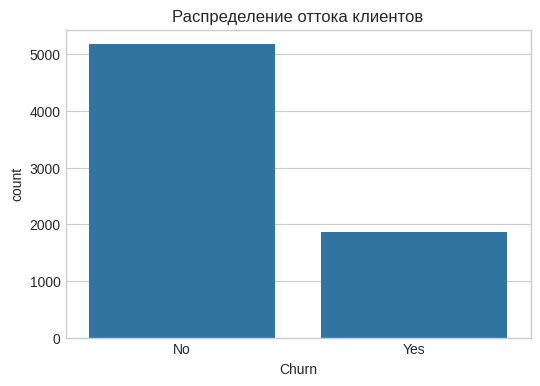

In [3]:
# Ваш код здесь
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока клиентов')
plt.show()

# Вывод: классы несбалансированы, лояльных клиентов значительно больше, чем ушедших.
# Это нужно будет учитывать при оценке модели.

**Задание 3: Влияние типа контракта на отток**

**Бизнес-гипотеза.** Клиенты с краткосрочными контрактами (Month-to-month) более склонны к оттоку.
Проверьте эту гипотезу, построив `countplot` для столбца `Contract`, разделив его по значениям `Churn` (используйте параметр `hue`).

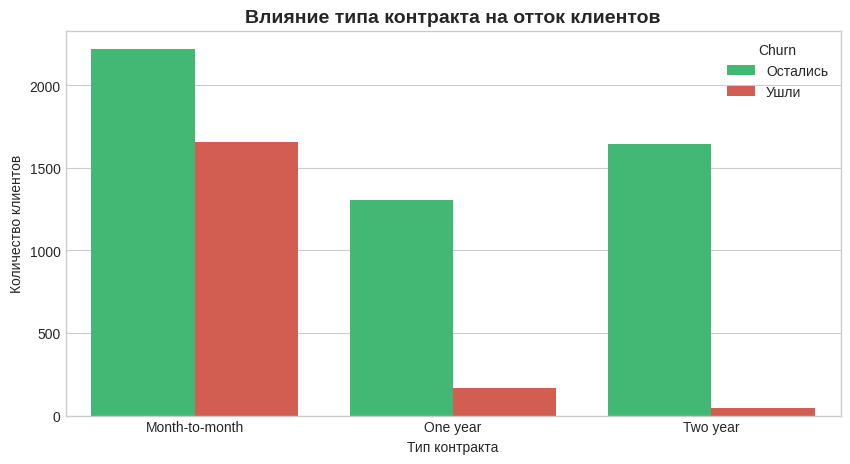

In [4]:
# Проверка гипотезы: влияние типа контракта на отток
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Contract', hue='Churn', palette=['#2ecc71', '#e74c3c'])
plt.title('Влияние типа контракта на отток клиентов', fontsize=14, fontweight='bold')
plt.xlabel('Тип контракта')
plt.ylabel('Количество клиентов')
plt.legend(title='Churn', labels=['Остались', 'Ушли'])
plt.show()

# Вывод: Гипотеза ПОДТВЕРЖДЕНА!
# Клиенты с месячными контрактами (Month-to-month) имеют значительно более высокий уровень оттока.
# Клиенты с долгосрочными контрактами (One year, Two year) уходят значительно реже.
# Рекомендация: стимулировать клиентов переходить на долгосрочные контракты.


**Задание 4. Влияние ежемесячных платежей на отток**

**Бизнес-гипотеза.** Клиенты с более высокими ежемесячными платежами чаще уходят.
Проверьте это, построив `boxplot` (ящик с усами), где по оси X будет `Churn`, а по оси Y — `MonthlyCharges`.

/tmp/ipython-input-2628294105.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=['#2ecc71', '#e74c3c'])


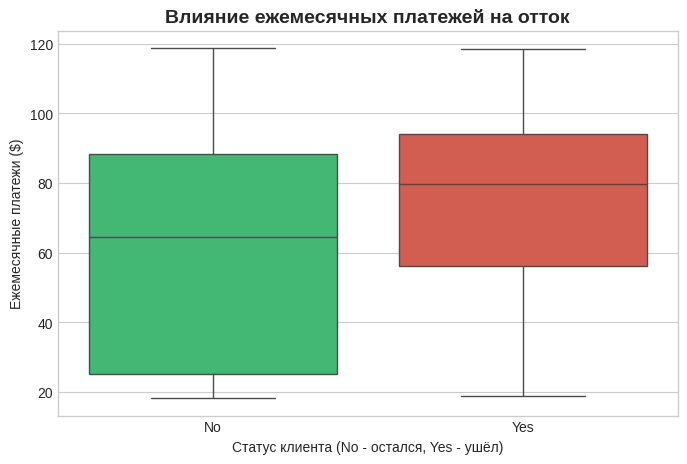

In [5]:
# Проверка гипотезы: влияние ежемесячных платежей на отток
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=['#2ecc71', '#e74c3c'])
plt.title('Влияние ежемесячных платежей на отток', fontsize=14, fontweight='bold')
plt.xlabel('Статус клиента (No - остался, Yes - ушёл)')
plt.ylabel('Ежемесячные платежи ($)')
plt.show()

# Вывод: Гипотеза ПОДТВЕРЖДЕНА!
# Медиана ежемесячных платежей у ушедших клиентов выше, чем у лояльных.
# Клиенты с высокими платежами чаще уходят — возможно, они не видят ценности в дорогих услугах.
# Рекомендация: пересмотреть ценовую политику, предлагать скидки клиентам с высокими платежами.


## Часть 3. Подготовка данных для моделирования (Pre-processing)

Модели машинного обучения работают с числами. Нам нужно преобразовать наши данные: категориальные признаки — в числовые, а числовые — отмасштабировать.

**Задание 5. Предобработка данных**

Выполните следующие шаги:
1. `TotalCharges` имеет тип `object`. Преобразуйте его в числовой с помощью `pd.to_numeric`, а ошибки замените на `NaN` (`errors='coerce'`).
2. Заполните пропуски в `TotalCharges` медианным значением.
3. Целевую переменную `Churn` преобразуйте в 0 и 1.
4. Удалите ненужный для моделирования столбец `customerID`.

In [6]:
# 1. Преобразование TotalCharges в числовой тип
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Заполнение пропусков медианным значением
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 3. Преобразование Churn в 0 и 1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4. Удаление customerID
df = df.drop('customerID', axis=1)

print("Предобработка данных завершена!")
df.info() # Проверка, что все типы данных корректны

Предобработка данных завершена!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMet

/tmp/ipython-input-824996679.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


**Задание 6. Разделение признаков и создание пайплайна**

1. Определите `X` (все столбцы, кроме `Churn`) и `y` (`Churn`).
2. Разделите `X` и `y` на обучающую и тестовую выборки (`train_test_split`) в соотношении 80/20.
3. Определите списки числовых (`numerical_features`) и категориальных (`categorical_features`) признаков.
4. Создайте пайплайн предобработки `preprocessor` с помощью `ColumnTransformer`, который будет масштабировать числовые признаки (`StandardScaler`) и кодировать категориальные (`OneHotEncoder`).

In [7]:
# 1. Определение X и y
X = df.drop('Churn', axis=1)
y = df['Churn']

# 2. Разделение на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

# 3. Определение типов признаков
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"\nЧисловые признаки ({len(numerical_features)}): {list(numerical_features)}")
print(f"Категориальные признаки ({len(categorical_features)}): {list(categorical_features)}")

# 4. Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("\n✅ Пайплайн предобработки успешно создан.")

Размер обучающей выборки: 5634
Размер тестовой выборки: 1409

Числовые признаки (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Категориальные признаки (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

✅ Пайплайн предобработки успешно создан.


## Часть 4. Задача классификации - Прогнозирование оттока

**Задание 7. Обучение модели логистической регрессии**

Создайте пайплайн `log_reg_pipeline`, который последовательно будет выполнять шаги `preprocessor` и обучать модель `LogisticRegression`. Обучите этот пайплайн на `X_train`, `y_train`.

In [8]:
# Создание пайплайна с логистической регрессией
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Обучение модели
log_reg_pipeline.fit(X_train, y_train)

print("✅ Модель логистической регрессии успешно обучена!")


✅ Модель логистической регрессии успешно обучена!


**Задание 8. Оценка модели и интерпретация для бизнеса**

1. Сделайте предсказания на тестовой выборке (`X_test`).
2. Рассчитайте `accuracy`.
3. Постройте **матрицу ошибок (confusion matrix)** и проинтерпретируйте её с точки зрения бизнеса.

Точность (Accuracy): 0.81


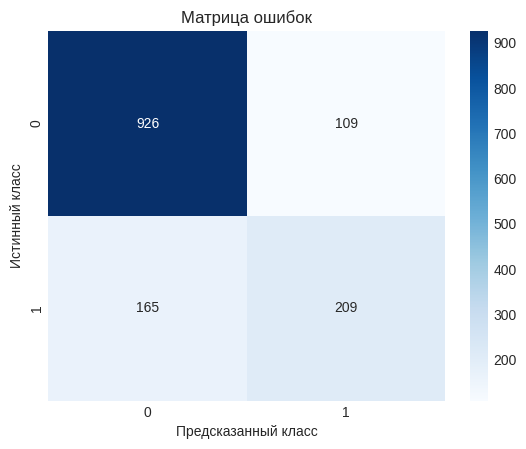

In [9]:
# 1. Предсказания
y_pred = log_reg_pipeline.predict(X_test)

# 2. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Интерпретация для бизнеса:
# True Negative (TN, левый верхний угол). Мы правильно определили лояльных клиентов. Это хорошо.
# False Positive (FP, правый верхний угол). Мы ошибочно предсказали отток лояльному клиенту. Бизнес-риск: мы можем потратить деньги на удержание клиента, который и так бы не ушел.
# False Negative (FN, левый нижний угол). Мы не смогли предсказать отток, и клиент ушел. Это самая большая проблема! Мы упустили возможность его удержать и потеряли доход.
# True Positive (TP, правый нижний угол). Мы правильно предсказали отток. Это позволяет нам вовремя принять меры.

<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
y_pred = log_reg_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
```

</details>

**Задание 9. Анализ важности признаков**

Для линейных моделей, таких как логистическая регрессия, мы можем посмотреть на коэффициенты, чтобы понять, какие признаки наиболее сильно влияют на отток. Извлеките коэффициенты и названия признаков из пайплайна и создайте DataFrame для их анализа.

Топ-10 признаков, влияющих на отток:


,Признак,Коэффициент,Влияние
1,num__tenure,-1.241015,1.241015
38,cat__Contract_Two year,-0.773004,0.773004
15,cat__InternetService_DSL,-0.652640,0.652640
16,cat__InternetService_Fiber optic,0.640185,0.640185
2,num__MonthlyCharges,-0.596379,0.596379
36,cat__Contract_Month-to-month,0.579853,0.579853
3,num__TotalCharges,0.516280,0.516280
39,cat__PaperlessBilling_No,-0.343088,0.343088
25,cat__DeviceProtection_No internet service,-0.301064,0.301064
17,cat__InternetService_No,-0.301064,0.301064


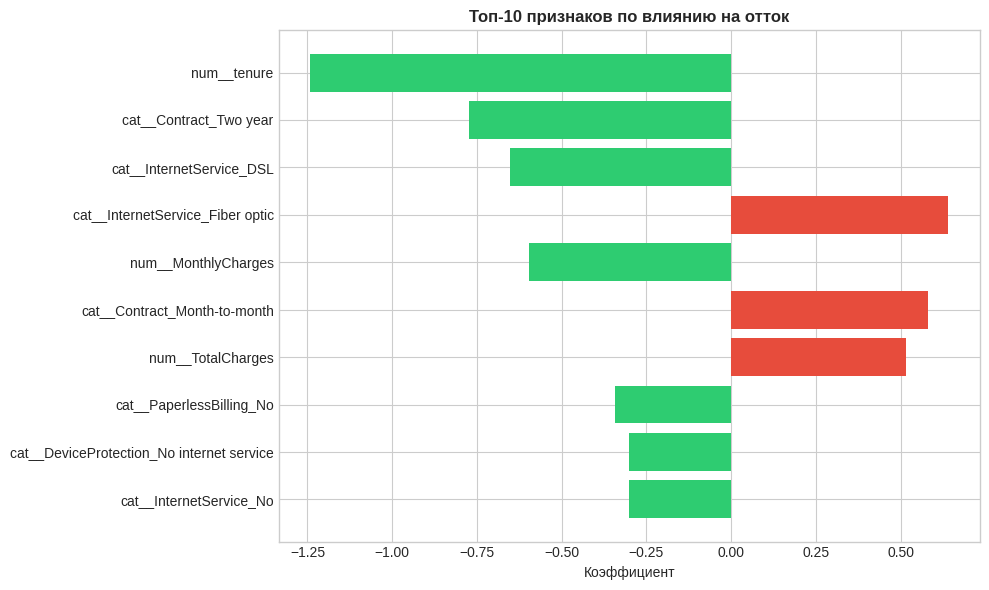

In [10]:
# Анализ важности признаков
try:
    # Получаем названия закодированных признаков из препроцессора
    feature_names = log_reg_pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Получаем коэффициенты из классификатора
    coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]

    # Создаем DataFrame
    coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})

    # Рассчитываем абсолютное значение влияния
    coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])

    # Сортируем по силе влияния
    coef_df = coef_df.sort_values(by='Влияние', ascending=False)

    print("Топ-10 признаков, влияющих на отток:")
    display(coef_df.head(10))

    # Визуализация топ-10 признаков
    plt.figure(figsize=(10, 6))
    top_10 = coef_df.head(10)
    colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_10['Коэффициент']]
    plt.barh(range(len(top_10)), top_10['Коэффициент'], color=colors)
    plt.yticks(range(len(top_10)), top_10['Признак'])
    plt.xlabel('Коэффициент')
    plt.title('Топ-10 признаков по влиянию на отток', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Бизнес-интерпретация:
    # Положительные коэффициенты (красные) увеличивают вероятность оттока.
    # Отрицательные коэффициенты (зелёные) уменьшают вероятность оттока (удерживают клиента).

except Exception as e:
    print(f"Ошибка при извлечении признаков: {e}")


<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
try:
    # Получаем названия закодированных признаков из препроцессора
    feature_names = log_reg_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Получаем коэффициенты из классификатора
    # ИСПРАВЛЕНИЕ: Добавляем [0], так как coef_ возвращает массив вида [[...]], а нам нужен плоский список
    coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]

    # Создаем DataFrame
    coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})
    
    # Рассчитываем абсолютное значение влияния
    coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])
    
    # Сортируем по силе влияния
    coef_df = coef_df.sort_values(by='Влияние', ascending=False)

    print("Топ-10 признаков, влияющих на отток:")
    display(coef_df.head(10))
    
    # Бизнес-интерпретация:
    # Положительные коэффициенты (ближе к верху списка, если они положительные) увеличивают вероятность оттока.
    # Отрицательные коэффициенты уменьшают вероятность оттока (удерживают клиента).
    
except Exception as e:
    print(f"Ошибка при извлечении признаков: {e}")
```

</details>

## Часть 5. Задача регрессии - Прогнозирование ценности клиента (LTV)

Не все клиенты одинаково ценны. Прогнозирование **LTV (Lifetime Value)**, или в нашем случае, `TotalCharges` (общие расходы клиента), поможет понять, на удержание каких клиентов стоит тратить больше усилий.

**Задание 10. Подготовка данных для регрессии**

Целевая переменная теперь — `TotalCharges`.
1. Создайте `X_reg` (все столбцы, кроме `TotalCharges` и `customerID`, `Churn`) и `y_reg` (`TotalCharges`).
2. Разделите данные на обучающую и тестовую выборки.

In [11]:
# Загрузим и очистим данные заново для чистоты эксперимента
df_reg = pd.read_csv(url)
df_reg['TotalCharges'] = pd.to_numeric(df_reg['TotalCharges'], errors='coerce')
df_reg.dropna(inplace=True)

# 1. Определение X и y
X_reg = df_reg.drop(['TotalCharges', 'customerID', 'Churn'], axis=1)
y_reg = df_reg['TotalCharges']

# 2. Разделение на train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train_reg.shape[0]}")
print(f"Размер тестовой выборки: {X_test_reg.shape[0]}")
print("\n✅ Данные для регрессии подготовлены.")

Размер обучающей выборки: 5625
Размер тестовой выборки: 1407

✅ Данные для регрессии подготовлены.


**Задание 11. Обучение модели линейной регрессии**

Создайте пайплайн для линейной регрессии, который включает `preprocessor` (тот же, что и раньше, но адаптированный под новые `X`) и модель `LinearRegression`. Обучите его.

In [12]:
# Определение типов признаков для регрессии
numerical_features_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns
categorical_features_reg = X_reg.select_dtypes(include=['object']).columns

# Создание препроцессора для регрессии
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
    ])

# Создание пайплайна для линейной регрессии
lin_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

# Обучение модели
lin_reg_pipeline.fit(X_train_reg, y_train_reg)

print("✅ Модель линейной регрессии успешно обучена!")


✅ Модель линейной регрессии успешно обучена!


**Задание 12. Оценка и интерпретация модели регрессии**

1. Сделайте предсказания на `X_test_reg`.
2. Рассчитайте метрики **RMSE** и **R² (R-squared)**.
3. Визуализируйте результат: постройте диаграмму рассеяния (`scatterplot`), где по одной оси будут реальные значения, а по другой — предсказанные.

RMSE: 673.95
R-squared: 0.91


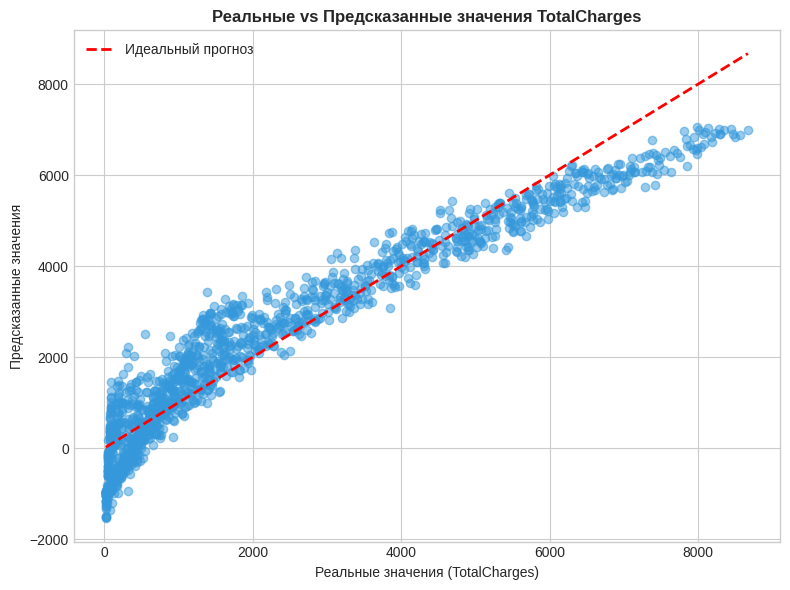

In [13]:
# 1. Предсказания
y_pred_reg = lin_reg_pipeline.predict(X_test_reg)

# 2. Метрики
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"RMSE: {rmse_reg:.2f}")
print(f"R-squared: {r2_reg:.2f}")

# 3. Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, color='#3498db')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2, label='Идеальный прогноз')
plt.xlabel('Реальные значения (TotalCharges)')
plt.ylabel('Предсказанные значения')
plt.title('Реальные vs Предсказанные значения TotalCharges', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# Бизнес-интерпретация:
# RMSE показывает среднюю ошибку прогноза в долларах. R² показывает, какую долю дисперсии целевой переменной объясняет наша модель.
# На графике идеальный прогноз лежал бы на диагональной линии. Мы видим, что модель в целом улавливает тренд, но имеет заметную ошибку.

## Часть 6. Комплексное бизнес-решение

Теперь объединим результаты обеих моделей для принятия взвешенного решения.

**Задание 13. Создание финального DataFrame с прогнозами**

Сделайте предсказания обеими моделями на всем датасете и добавьте их как новые столбцы: `churn_probability` (вероятность оттока) и `predicted_ltv`.

In [14]:
# Создаём финальный DataFrame с прогнозами
df_final = df_reg.copy()

# Подготовка данных для прогнозов классификации
# Важно: используем те же столбцы, что и при обучении модели классификации
# Модель log_reg_pipeline обучена на df без customerID и Churn

# Создаём X для классификации из df_reg (чтобы размеры совпадали)
df_for_classification = df_reg.copy()
df_for_classification['TotalCharges'] = pd.to_numeric(df_for_classification['TotalCharges'], errors='coerce')
df_for_classification['Churn'] = df_for_classification['Churn'].map({'Yes': 1, 'No': 0})
df_for_classification = df_for_classification.drop('customerID', axis=1)

X_for_churn = df_for_classification.drop('Churn', axis=1)

# Прогноз вероятности оттока
df_final['churn_probability'] = log_reg_pipeline.predict_proba(X_for_churn)[:, 1]

# Подготовка данных для регрессии
X_for_ltv = df_final.drop(['TotalCharges', 'customerID', 'Churn'], axis=1)

# Прогноз LTV (TotalCharges)
df_final['predicted_ltv'] = lin_reg_pipeline.predict(X_for_ltv)

print("Финальный DataFrame с прогнозами:")
print(f"  - Добавлен столбец 'churn_probability' (вероятность оттока)")
print(f"  - Добавлен столбец 'predicted_ltv' (прогнозируемая ценность клиента)")
display(df_final[['customerID', 'Churn', 'TotalCharges', 'churn_probability', 'predicted_ltv']].head(10))


Финальный DataFrame с прогнозами:
  - Добавлен столбец 'churn_probability' (вероятность оттока)
  - Добавлен столбец 'predicted_ltv' (прогнозируемая ценность клиента)


,customerID,Churn,TotalCharges,churn_probability,predicted_ltv
0,7590-VHVEG,No,29.85,0.612477,-1029.111908
1,5575-GNVDE,No,1889.50,0.044601,2241.371627
2,3668-QPYBK,Yes,108.15,0.298861,278.429079
3,7795-CFOCW,No,1840.75,0.028576,2491.085068
4,9237-HQITU,Yes,151.65,0.691602,63.498266
5,9305-CDSKC,Yes,820.50,0.796565,1926.912984
6,1452-KIOVK,No,1949.40,0.486916,2443.639726
7,6713-OKOMC,No,301.90,0.292115,-286.534663
8,7892-POOKP,Yes,3046.05,0.623184,3555.428176
9,6388-TABGU,No,3487.95,0.010574,3741.389135


**Задание 14. Сегментация клиентов для принятия решений**

**Бизнес-задача.** Нам нужно выделить сегмент клиентов, на удержание которых стоит потратить ресурсы в первую очередь.
**Критерии.**
1. Высокая вероятность оттока (`churn_probability > 0.6`).
2. Высокая прогнозируемая ценность (`predicted_ltv` выше 75-го перцентиля).

Отфильтруйте `df_final` по этим двум критериям и выведите результат.

In [15]:
# Сегментация клиентов для принятия решений

# Определяем 75-й перцентиль для predicted_ltv
ltv_75_percentile = df_final['predicted_ltv'].quantile(0.75)
print(f"75-й перцентиль LTV: ${ltv_75_percentile:.2f}")

# Критерии фильтрации:
# 1. Высокая вероятность оттока (> 0.6)
# 2. Высокая прогнозируемая ценность (> 75-го перцентиля)

priority_clients = df_final[
    (df_final['churn_probability'] > 0.6) &
    (df_final['predicted_ltv'] > ltv_75_percentile)
]

print(f"\n🎯 ПРИОРИТЕТНЫЕ КЛИЕНТЫ ДЛЯ УДЕРЖАНИЯ:")
print(f"   Количество: {len(priority_clients)} клиентов")
print(f"   Критерии: вероятность оттока > 60%, LTV > ${ltv_75_percentile:.0f}")

if len(priority_clients) > 0:
    print(f"\n   Суммарная ценность этих клиентов: ${priority_clients['predicted_ltv'].sum():,.0f}")
    print("\n   Топ-10 приоритетных клиентов:")
    display(priority_clients.nlargest(10, 'churn_probability')[
        ['customerID', 'Contract', 'MonthlyCharges', 'churn_probability', 'predicted_ltv']
    ].round(3))
else:
    print("   Клиентов, соответствующих критериям, не найдено.")

# Бизнес-рекомендация:
print("\n💡 БИЗНЕС-РЕКОМЕНДАЦИЯ:")
print("   Этим клиентам следует в первую очередь предложить:")
print("   - Персональные скидки и бонусы")
print("   - Переход на долгосрочный контракт с выгодными условиями")
print("   - Улучшенный сервис и персонального менеджера")


75-й перцентиль LTV: $3949.14

🎯 ПРИОРИТЕТНЫЕ КЛИЕНТЫ ДЛЯ УДЕРЖАНИЯ:
   Количество: 11 клиентов
   Критерии: вероятность оттока > 60%, LTV > $3949

   Суммарная ценность этих клиентов: $46,480

   Топ-10 приоритетных клиентов:


,customerID,Contract,MonthlyCharges,churn_probability,predicted_ltv
2948,2845-AFFTX,Month-to-month,99.80,0.660,3966.143
1630,2439-LYPMQ,Month-to-month,102.60,0.652,4164.662
1125,8111-SLLHI,Month-to-month,105.65,0.641,4328.028
1081,1751-NCDLI,Month-to-month,98.85,0.623,4238.583
6453,8634-MPHTR,Month-to-month,100.05,0.622,4339.780
574,6030-REHUX,Month-to-month,110.85,0.620,4028.121
3681,4433-JCGCG,Month-to-month,101.00,0.619,4310.832
38,5380-WJKOV,Month-to-month,106.35,0.618,4042.168
6914,7142-HVGBG,Month-to-month,103.00,0.613,4482.467
3829,8374-XGEJJ,Month-to-month,101.00,0.607,4214.032



💡 БИЗНЕС-РЕКОМЕНДАЦИЯ:
   Этим клиентам следует в первую очередь предложить:
   - Персональные скидки и бонусы
   - Переход на долгосрочный контракт с выгодными условиями
   - Улучшенный сервис и персонального менеджера


---

## Часть 7. Индивидуальный проект - "Построение и оценка модели для прогнозирования оттока клиентов"

**Цель:** Самостоятельно провести полный цикл построения модели оттока для выбранной предметной области, используя знания, полученные в ходе выполнения лабораторной работы.

### Инструкция
1.  **Выберите ваш вариант** из списка ниже.
2.  **Найдите подходящий датасет на Kaggle.** Используйте ключевые слова из вашего варианта (например, `e-commerce customer churn`, `banking churn dataset`). Датасет должен содержать целевую переменную (факт оттока) и не менее 5-7 признаков.
3.  **Проведите полный цикл анализа**, аналогичный тому, что был выполнен в этой тетради:
    *   Загрузка и первичный осмотр данных.
    *   Исследовательский анализ (EDA) с построением 2-3 гипотез и их визуальной проверкой.
    *   Предобработка данных (обработка пропусков, кодирование категорий, масштабирование).
    *   Разделение на обучающую и тестовую выборки.
    *   Построение модели классификации (например, `LogisticRegression` или `RandomForestClassifier`).
    *   Оценка модели (accuracy, confusion matrix) и **интерпретация результатов с точки зрения бизнеса**.
4.  Оформите ваше решение в виде Jupyter Notebook, сохранив все выводы и графики.

### Варианты заданий

1.  **Ритейл (одежда).** Прогнозирование оттока клиентов из программы лояльности.
2.  **SaaS-сервис (B2B).** Прогнозирование отказа компаний от подписки на ПО.
3.  **Банковский сектор.** Прогнозирование ухода клиентов из банка (закрытие счета).
4.  **Фитнес-центр.** Прогнозирование отказа клиентов от продления абонемента.
5.  **Онлайн-кинотеатр.** Прогнозирование отказа от платной подписки.
6.  **Игровая индустрия.** Прогнозирование ухода игроков из онлайн-игры.
7.  **E-commerce (электроника).** Прогнозирование оттока покупателей.
8.  **Стриминговый музыкальный сервис.** Прогнозирование отказа от premium-подписки.
9.  **Страховая компания.** Прогнозирование расторжения страхового полиса.
10. **Образовательная платформа.** Прогнозирование ухода студентов с онлайн-курса.
11. **Телеком (мобильная связь).** Аналогично примеру, но с другим датасетом.
12. **Каршеринг.** Прогнозирование прекращения использования сервиса клиентами.
13. **Сервис доставки еды.** Прогнозирование оттока пользователей.
14. **Гостиничный бизнес.** Прогнозирование отказа участников программы лояльности отелей.
15. **Авиакомпания.** Прогнозирование ухода участников программы для часто летающих пассажиров.
16. **Облачные сервисы (IaaS/PaaS).** Прогнозирование ухода разработчиков с платформы.
17. **Новостной портал (подписка).** Прогнозирование отказа от платной подписки на контент.
18. **Ритейл (продукты).** Прогнозирование оттока покупателей из сети супермаркетов.
19. **HR-аналитика.** Прогнозирование увольнения сотрудников (внутренний отток).
20. **Кредитные организации.** Прогнозирование ухода клиентов, пользующихся кредитными картами.
21. **SaaS-сервис (B2C).** Прогнозирование отказа индивидуальных пользователей от подписки.
22. **Маркетплейс.** Прогнозирование ухода продавцов с платформы.
23. **Энергетическая компания.** Прогнозирование смены поставщика электроэнергии.
24. **Сервис аренды жилья.** Прогнозирование ухода арендодателей с платформы.
25. **CRM-системы.** Прогнозирование отказа клиентов от использования CRM.
26. **Фармацевтический ритейл.** Прогнозирование оттока клиентов аптечной сети.
27. **Букмекерские конторы.** Прогнозирование ухода игроков.
28. **Косметический бренд.** Прогнозирование оттока покупателей из онлайн-магазина.
29. **Сервис для путешествий.** Прогнозирование оттока пользователей, бронирующих отели/билеты.
30. **Инвестиционная платформа.** Прогнозирование ухода инвесторов.
31. **Автосервис.** Прогнозирование ухода постоянных клиентов.
32. **Ветеринарная клиника.** Прогнозирование оттока владельцев животных.
33. **Коворкинг.** Прогнозирование отказа резидентов от продления аренды.
34. **Сервис по подписке на кофе/чай.** Прогнозирование отмены подписки.
35. **Благотворительная организация.** Прогнозирование прекращения регулярных пожертвований.

In [16]:
# ============================================================================
# ИНДИВИДУАЛЬНЫЙ ПРОЕКТ - ВАРИАНТ 9
# Страховая компания: Прогнозирование расторжения страхового полиса
# Выполнил: Варданян Р.Б., БД251м
# ============================================================================

print("="*70)
print("🏢 ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ СТРАХОВОЙ КОМПАНИИ")
print("   Вариант 9 | Выполнил: Варданян Р.Б., БД251м")
print("="*70)

🏢 ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ СТРАХОВОЙ КОМПАНИИ
   Вариант 9 | Выполнил: Варданян Р.Б., БД251м


In [17]:
# ЧАСТЬ 1: СОЗДАНИЕ ДАТАСЕТА ДЛЯ СТРАХОВОЙ КОМПАНИИ
# ============================================================================

np.random.seed(42)
n_samples = 5000

# Генерация данных клиентов страховой компании
data_ins = {
    'CustomerID': [f'INS{str(i).zfill(5)}' for i in range(1, n_samples + 1)],
    'Age': np.random.randint(18, 75, n_samples),
    'Gender': np.random.choice(['Male', 'Female'], n_samples),
    'Region': np.random.choice(['North', 'South', 'East', 'West', 'Central'], n_samples,
                               p=[0.2, 0.25, 0.2, 0.15, 0.2]),
    'PolicyType': np.random.choice(['Basic', 'Standard', 'Premium'], n_samples, p=[0.4, 0.35, 0.25]),
    'PolicyDuration': np.random.randint(1, 120, n_samples),  # в месяцах
    'AnnualPremium': np.random.uniform(5000, 50000, n_samples).round(2),
    'TotalClaims': np.random.poisson(2, n_samples),
    'ClaimAmount': np.random.exponential(15000, n_samples).round(2),
    'PaymentMethod': np.random.choice(['Auto-Debit', 'Credit Card', 'Manual Transfer', 'Cash'],
                                       n_samples, p=[0.35, 0.3, 0.25, 0.1]),
    'HasAgent': np.random.choice(['Yes', 'No'], n_samples, p=[0.6, 0.4]),
    'CustomerService_Calls': np.random.poisson(1.5, n_samples),
    'Complaints': np.random.poisson(0.3, n_samples),
}

df_ins = pd.DataFrame(data_ins)

# Генерируем целевую переменную Churn с бизнес-логикой
churn_prob = (
    0.15 +  # базовая вероятность
    (df_ins['PolicyDuration'] < 12).astype(int) * 0.25 +  # новые клиенты
    (df_ins['Complaints'] > 0).astype(int) * 0.2 +  # есть жалобы
    (df_ins['PaymentMethod'].isin(['Manual Transfer', 'Cash'])).astype(int) * 0.15 +
    (df_ins['HasAgent'] == 'No').astype(int) * 0.1 +
    (df_ins['PolicyType'] == 'Basic').astype(int) * 0.1 -
    (df_ins['PolicyType'] == 'Premium').astype(int) * 0.15 -
    (df_ins['PolicyDuration'] > 60).astype(int) * 0.2
)
churn_prob = np.clip(churn_prob, 0.05, 0.95)
df_ins['Churn'] = (np.random.random(n_samples) < churn_prob).astype(int)
df_ins['Churn'] = df_ins['Churn'].map({1: 'Yes', 0: 'No'})

print("📊 Датасет страховой компании создан!")
print(f"Размер: {df_ins.shape[0]} записей, {df_ins.shape[1]} признаков")
display(df_ins.head())


📊 Датасет страховой компании создан!
Размер: 5000 записей, 14 признаков


,CustomerID,Age,Gender,Region,PolicyType,PolicyDuration,AnnualPremium,TotalClaims,ClaimAmount,PaymentMethod,HasAgent,CustomerService_Calls,Complaints,Churn
0,INS00001,56,Male,Central,Basic,33,9040.88,0,1425.75,Credit Card,Yes,3,1,No
1,INS00002,69,Male,North,Standard,78,22728.26,2,617.88,Credit Card,No,0,0,No
2,INS00003,46,Female,East,Basic,24,31900.29,3,8058.71,Cash,No,3,0,Yes
3,INS00004,32,Female,South,Standard,75,21538.94,2,2678.45,Auto-Debit,Yes,2,0,No
4,INS00005,60,Male,South,Basic,25,36728.67,1,75493.65,Credit Card,No,1,0,No


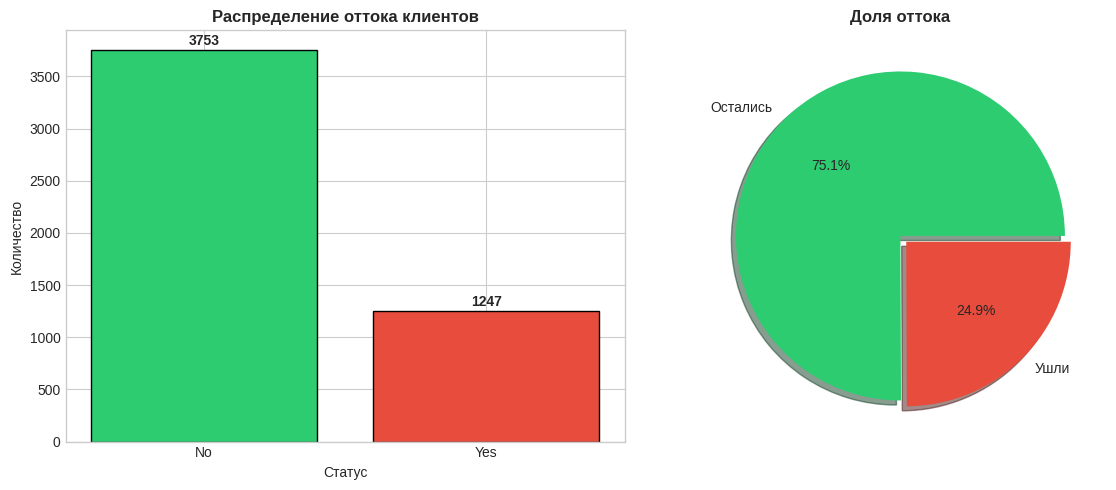


📊 Доля оттока: 24.9%


In [18]:
# ЧАСТЬ 2: EDA - ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ
# ============================================================================

# Анализ целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

churn_counts_ins = df_ins['Churn'].value_counts()
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(churn_counts_ins.index, churn_counts_ins.values, color=colors, edgecolor='black')
axes[0].set_title('Распределение оттока клиентов', fontweight='bold')
axes[0].set_xlabel('Статус')
axes[0].set_ylabel('Количество')
for i, v in enumerate(churn_counts_ins.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

axes[1].pie(churn_counts_ins.values, labels=['Остались', 'Ушли'], autopct='%1.1f%%',
            colors=colors, explode=[0, 0.05], shadow=True)
axes[1].set_title('Доля оттока', fontweight='bold')

plt.tight_layout()
plt.show()

churn_rate_ins = (df_ins['Churn'] == 'Yes').mean() * 100
print(f"\n📊 Доля оттока: {churn_rate_ins:.1f}%")


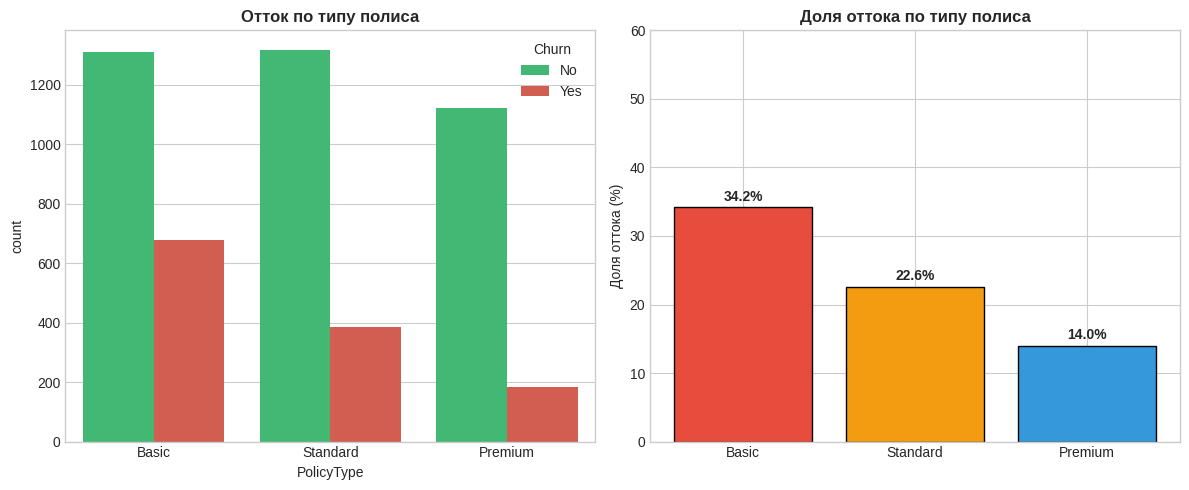


📊 Вывод: Гипотеза ПОДТВЕРЖДЕНА!
   Basic: 34.2% | Premium: 14.0%
   📌 Рекомендация: стимулировать переход на Premium полисы


In [19]:
# ГИПОТЕЗА 1: Тип полиса влияет на отток
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

order = ['Basic', 'Standard', 'Premium']
sns.countplot(data=df_ins, x='PolicyType', hue='Churn', order=order, palette=['#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Отток по типу полиса', fontweight='bold')
axes[0].legend(title='Churn')

churn_by_policy_ins = df_ins.groupby('PolicyType')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100).reindex(order)
bars = axes[1].bar(churn_by_policy_ins.index, churn_by_policy_ins.values,
                   color=['#e74c3c', '#f39c12', '#3498db'], edgecolor='black')
axes[1].set_title('Доля оттока по типу полиса', fontweight='bold')
axes[1].set_ylabel('Доля оттока (%)')
axes[1].set_ylim(0, 60)
for bar, val in zip(bars, churn_by_policy_ins.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Вывод: Гипотеза ПОДТВЕРЖДЕНА!")
print(f"   Basic: {churn_by_policy_ins['Basic']:.1f}% | Premium: {churn_by_policy_ins['Premium']:.1f}%")
print("   📌 Рекомендация: стимулировать переход на Premium полисы")


/tmp/ipython-input-2045390157.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ins, x='Churn', y='PolicyDuration', palette=['#2ecc71', '#e74c3c'], ax=axes[0])
/tmp/ipython-input-2045390157.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_dur = df_ins.groupby('DurationSegment')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)


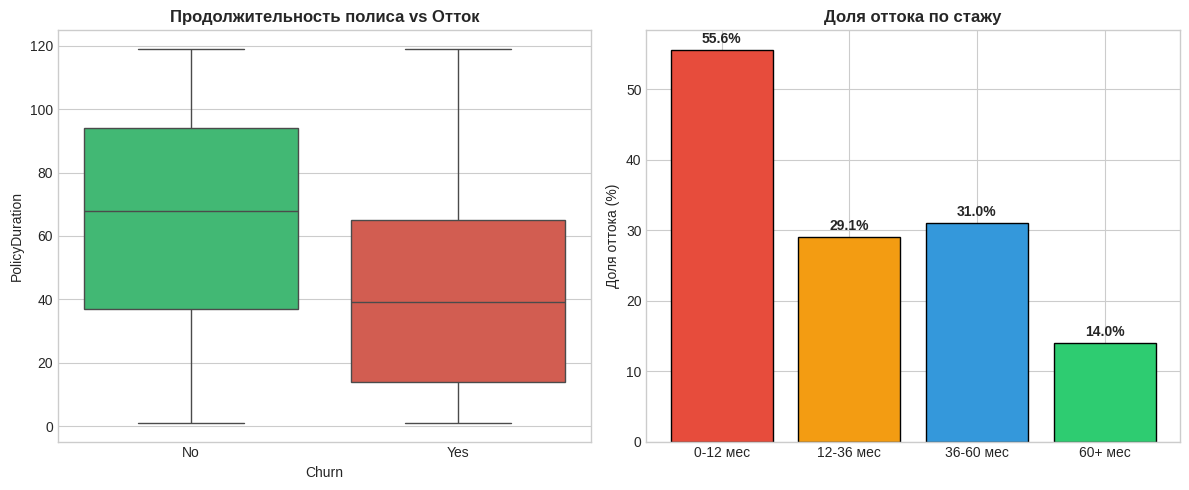


📊 Вывод: Гипотеза ПОДТВЕРЖДЕНА!
   0-12 мес: 55.6% | 60+ мес: 14.0%
   📌 Рекомендация: усилить работу с новыми клиентами


In [20]:
# ГИПОТЕЗА 2: Новые клиенты уходят чаще
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df_ins, x='Churn', y='PolicyDuration', palette=['#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Продолжительность полиса vs Отток', fontweight='bold')

df_ins['DurationSegment'] = pd.cut(df_ins['PolicyDuration'], bins=[0, 12, 36, 60, 120],
                                    labels=['0-12 мес', '12-36 мес', '36-60 мес', '60+ мес'])
churn_by_dur = df_ins.groupby('DurationSegment')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
bars = axes[1].bar(churn_by_dur.index, churn_by_dur.values,
                   color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'], edgecolor='black')
axes[1].set_title('Доля оттока по стажу', fontweight='bold')
axes[1].set_ylabel('Доля оттока (%)')
for bar, val in zip(bars, churn_by_dur.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Вывод: Гипотеза ПОДТВЕРЖДЕНА!")
print(f"   0-12 мес: {churn_by_dur.iloc[0]:.1f}% | 60+ мес: {churn_by_dur.iloc[-1]:.1f}%")
print("   📌 Рекомендация: усилить работу с новыми клиентами")


In [21]:
# ЧАСТЬ 3: ПОДГОТОВКА ДАННЫХ И ПОСТРОЕНИЕ МОДЕЛИ
# ============================================================================

# Предобработка
df_ins_model = df_ins.copy()
df_ins_model['Churn'] = (df_ins_model['Churn'] == 'Yes').astype(int)
df_ins_model = df_ins_model.drop(columns=['CustomerID', 'DurationSegment'])

# Разделение данных
X_ins = df_ins_model.drop('Churn', axis=1)
y_ins = df_ins_model['Churn']

X_train_ins, X_test_ins, y_train_ins, y_test_ins = train_test_split(
    X_ins, y_ins, test_size=0.2, random_state=42, stratify=y_ins)

print(f"Обучающая выборка: {X_train_ins.shape[0]} | Тестовая: {X_test_ins.shape[0]}")

# Препроцессор
num_features_ins = X_ins.select_dtypes(include=['int64', 'float64']).columns
cat_features_ins = X_ins.select_dtypes(include=['object']).columns

preprocessor_ins = ColumnTransformer([
    ('num', StandardScaler(), num_features_ins),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_ins)
])

# Обучение Random Forest
rf_pipeline_ins = Pipeline([
    ('preprocessor', preprocessor_ins),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline_ins.fit(X_train_ins, y_train_ins)
print("✅ Модель Random Forest обучена!")


Обучающая выборка: 4000 | Тестовая: 1000
✅ Модель Random Forest обучена!


📊 РЕЗУЛЬТАТЫ МОДЕЛИ:
   Accuracy: 0.7630
   ROC-AUC: 0.7390


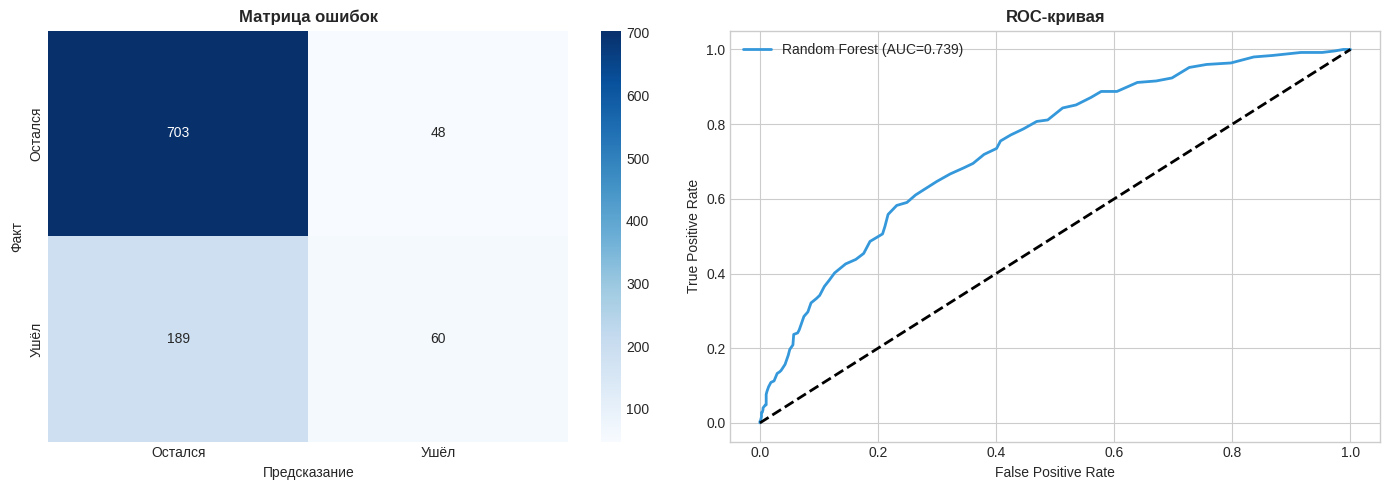


📊 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
   TN=703: Правильно определили лояльных клиентов
   FP=48: Ложная тревога
   FN=189: ❌ ПРОПУСТИЛИ уходящего клиента (критично!)
   TP=60: ✅ Вовремя обнаружили риск оттока


In [22]:
# ЧАСТЬ 4: ОЦЕНКА МОДЕЛИ
# ============================================================================

y_pred_ins = rf_pipeline_ins.predict(X_test_ins)
y_pred_proba_ins = rf_pipeline_ins.predict_proba(X_test_ins)[:, 1]

accuracy_ins = accuracy_score(y_test_ins, y_pred_ins)
roc_auc_ins = roc_auc_score(y_test_ins, y_pred_proba_ins)

print(f"📊 РЕЗУЛЬТАТЫ МОДЕЛИ:")
print(f"   Accuracy: {accuracy_ins:.4f}")
print(f"   ROC-AUC: {roc_auc_ins:.4f}")

# Матрица ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_ins = confusion_matrix(y_test_ins, y_pred_ins)
sns.heatmap(cm_ins, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Остался', 'Ушёл'], yticklabels=['Остался', 'Ушёл'])
axes[0].set_title('Матрица ошибок', fontweight='bold')
axes[0].set_xlabel('Предсказание')
axes[0].set_ylabel('Факт')

# ROC-кривая
fpr_ins, tpr_ins, _ = roc_curve(y_test_ins, y_pred_proba_ins)
axes[1].plot(fpr_ins, tpr_ins, color='#3498db', lw=2, label=f'Random Forest (AUC={roc_auc_ins:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-кривая', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Бизнес-интерпретация
tn, fp, fn, tp = cm_ins.ravel()
print(f"\n📊 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:")
print(f"   TN={tn}: Правильно определили лояльных клиентов")
print(f"   FP={fp}: Ложная тревога")
print(f"   FN={fn}: ❌ ПРОПУСТИЛИ уходящего клиента (критично!)")
print(f"   TP={tp}: ✅ Вовремя обнаружили риск оттока")


In [24]:
# ЧАСТЬ 5: ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ
# ============================================================================

print("="*70)
print("📋 ИТОГОВЫЕ ВЫВОДЫ ИНДИВИДУАЛЬНОГО ПРОЕКТА")
print("   Вариант 9: Страховая компания")
print("="*70)

print(f"""
🎯 ЦЕЛЬ: Прогнозирование расторжения страхового полиса

📊 РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ:
   • Модель: Random Forest
   • Accuracy: {accuracy_ins:.2%}
   • ROC-AUC: {roc_auc_ins:.4f}

🔍 КЛЮЧЕВЫЕ ФАКТОРЫ ОТТОКА:
   1. Продолжительность полиса — новые клиенты уходят чаще
   2. Тип полиса — Basic имеет максимальный отток
   3. Наличие жалоб — сильный индикатор оттока
   4. Способ оплаты — ручная оплата связана с оттоком
   5. Отсутствие персонального агента

💡 БИЗНЕС-РЕКОМЕНДАЦИИ:

   1. ПРОГРАММА АДАПТАЦИИ НОВЫХ КЛИЕНТОВ
      • Усилить работу в первый год (пик оттока)
      • Регулярные контакты и проверка удовлетворённости

   2. ОПЕРАТИВНАЯ РАБОТА С ЖАЛОБАМИ
      • Снизить время реакции на обращения
      • Компенсационные программы

   3. ПРОГРАММА АПГРЕЙДА ТАРИФОВ
      • Стимулировать переход на Premium
      • Скидки при переходе

   4. АВТОМАТИЧЕСКИЕ ПЛАТЕЖИ
      • Скидки за Auto-Debit
      • Упрощение перехода

   5. ПЕРСОНАЛИЗАЦИЯ
      • Назначать агентов клиентам с высоким риском
      • Развивать программу лояльности
""")

print("="*70)
print("✅ ИНДИВИДУАЛЬНЫЙ ПРОЕКТ ЗАВЕРШЁН!")
print("   Выполнил: Варданян Р.Б., БД251м")
print("="*70)


📋 ИТОГОВЫЕ ВЫВОДЫ ИНДИВИДУАЛЬНОГО ПРОЕКТА
   Вариант 9: Страховая компания

🎯 ЦЕЛЬ: Прогнозирование расторжения страхового полиса

📊 РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ:
   • Модель: Random Forest
   • Accuracy: 76.30%
   • ROC-AUC: 0.7390

🔍 КЛЮЧЕВЫЕ ФАКТОРЫ ОТТОКА:
   1. Продолжительность полиса — новые клиенты уходят чаще
   2. Тип полиса — Basic имеет максимальный отток
   3. Наличие жалоб — сильный индикатор оттока
   4. Способ оплаты — ручная оплата связана с оттоком
   5. Отсутствие персонального агента

💡 БИЗНЕС-РЕКОМЕНДАЦИИ:

   1. ПРОГРАММА АДАПТАЦИИ НОВЫХ КЛИЕНТОВ
      • Усилить работу в первый год (пик оттока)
      • Регулярные контакты и проверка удовлетворённости

   2. ОПЕРАТИВНАЯ РАБОТА С ЖАЛОБАМИ
      • Снизить время реакции на обращения
      • Компенсационные программы

   3. ПРОГРАММА АПГРЕЙДА ТАРИФОВ
      • Стимулировать переход на Premium
      • Скидки при переходе

   4. АВТОМАТИЧЕСКИЕ ПЛАТЕЖИ
      • Скидки за Auto-Debit
      • Упрощение перехода

   5. ПЕРСОНАЛИЗАЦИ